In [1]:
!git clone https://github.com/Tanveer2719/NIDS_Coursework.git
%cd /kaggle/working/NIDS_Coursework/My_Code

Cloning into 'NIDS_Coursework'...
remote: Enumerating objects: 248, done.
remote: Counting objects: 100% (248/248), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 248 (delta 125), reused 207 (delta 84), pack-reused 0 (from 0)
Receiving objects: 100% (248/248), 205.71 KiB | 3.61 MiB/s, done.
Resolving deltas: 100% (125/125), done.
/kaggle/working/NIDS_Coursework/My_Code


In [2]:
!ls /kaggle/input

unsw-nb-15


In [3]:
import os
import random
import numpy as np
import tensorflow as tf

def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seed(42)


2025-08-17 15:11:40.203900: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755443500.392662      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755443500.452533      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import pandas as pd
import numpy as np

path = "/kaggle/input/unsw-nb-15/UNSW-NB15_combined.csv"

df = pd.read_csv(path)

print(df.shape)
df = df.drop(columns=['id', 'label'])
print(df.shape)

print(f"🧾 Unique class labels: {df['attack_cat'].unique()}")
df['label'] = df['attack_cat'].apply(lambda x: 0 if x == 'Normal' else 1)

print(f'Unique values for label {df["label"].unique()}')

df = df.drop(columns=["attack_cat"])
print(f'new shape{df.shape}')



# --------------------------- perform preprocessing--------------

from preprocess import Preprocess

# separate the features and labels so that the labesl are not encoded
labels = df['label']
features = df.drop(columns=['label'])

pp = Preprocess()
processed_features = pp.fit_transform_df_auto(df = features,n_categorical_levels=32, expected_categorical_format='onehot')

print(processed_features.shape)

# concat the features and the labels
processed_full_df = pd.concat([processed_features, labels], axis=1)

# Filter out categorical one-hot encoded columns
numerical_columns = [col for col in processed_full_df 
                     if not (col.startswith("proto_") or 
                             col.startswith("service_") or 
                             col.startswith("state_") or
                             col == 'label')]

target = processed_full_df['label']
features = processed_full_df.drop(columns=['label'])

(257673, 45)
(257673, 43)
🧾 Unique class labels: ['Normal' 'Backdoor' 'Analysis' 'Fuzzers' 'Shellcode' 'Reconnaissance'
 'Exploits' 'DoS' 'Worms' 'Generic']
Unique values for label [0 1]
new shape(257673, 43)
Encoding the 32 levels for proto
Encoding the 13 levels for service
Encoding the 11 levels for state
(257673, 95)


In [5]:
from record_level_embedding import RecordLevelEmbedder

embedder = RecordLevelEmbedder(selected_df = features, numerical_columns = numerical_columns, embed_dimension= 64)

embedded_df = embedder.transform_to_df()
embedded_df.head()

[INFO] Initializing RecordLevelEmbedder...
[INFO] Detecting categorical blocks...
[INFO] Detected 3 categorical blocks:
   - proto: 32 columns
   - service: 13 columns
   - state: 11 columns
[INFO] Embedder initialized with embedding dimension 64.
[INFO] Building Keras embedding model...
   - Adding numerical input: dur
   - Adding numerical input: spkts
   - Adding numerical input: dpkts
   - Adding numerical input: sbytes
   - Adding numerical input: dbytes
   - Adding numerical input: rate
   - Adding numerical input: sttl
   - Adding numerical input: dttl
   - Adding numerical input: sload
   - Adding numerical input: dload
   - Adding numerical input: sloss
   - Adding numerical input: dloss
   - Adding numerical input: sinpkt
   - Adding numerical input: dinpkt
   - Adding numerical input: sjit
   - Adding numerical input: djit
   - Adding numerical input: swin
   - Adding numerical input: stcpb
   - Adding numerical input: dtcpb
   - Adding numerical input: dwin
   - Adding nume

I0000 00:00:1755443515.727352      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755443515.727957      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


[INFO] Projection complete. Output embedding shape: (64,)
[INFO] Model build complete.
[INFO] Preparing inputs for embedding. Number of rows: 257673
   - Prepared numerical input: dur
   - Prepared numerical input: spkts
   - Prepared numerical input: dpkts
   - Prepared numerical input: sbytes
   - Prepared numerical input: dbytes
   - Prepared numerical input: rate
   - Prepared numerical input: sttl
   - Prepared numerical input: dttl
   - Prepared numerical input: sload
   - Prepared numerical input: dload
   - Prepared numerical input: sloss
   - Prepared numerical input: dloss
   - Prepared numerical input: sinpkt
   - Prepared numerical input: dinpkt
   - Prepared numerical input: sjit
   - Prepared numerical input: djit
   - Prepared numerical input: swin
   - Prepared numerical input: stcpb
   - Prepared numerical input: dtcpb
   - Prepared numerical input: dwin
   - Prepared numerical input: tcprtt
   - Prepared numerical input: synack
   - Prepared numerical input: ackdat
  

2025-08-17 15:11:57.269074: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_55}}


8053/8053 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step
[INFO] Embedding complete. Output shape: (257673, 64)
[INFO] Embedding DataFrame ready.


,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,...,embed_54,embed_55,embed_56,embed_57,embed_58,embed_59,embed_60,embed_61,embed_62,embed_63
0,0.526297,-0.274962,0.240046,0.175640,0.319582,0.166146,-0.400173,0.299557,-0.278061,-0.367071,...,0.239632,-0.532777,0.342142,0.636009,0.142315,0.567157,-0.027547,0.675332,0.262451,-0.256291
1,0.446926,-0.485022,0.346259,0.323633,0.321390,0.201763,-0.330970,0.181381,-0.308502,-0.448172,...,0.333167,-0.426263,0.119546,0.955216,-0.144012,0.463430,-0.061751,0.865791,0.051590,-0.186757
2,0.574880,-0.415946,0.315918,0.423030,0.160432,0.121868,-0.391887,0.107925,-0.385792,-0.428478,...,0.336697,-0.537757,0.248757,0.903345,0.011872,0.414185,-0.086681,0.946179,0.125380,-0.186142
3,0.474340,-0.401083,-0.002091,0.195434,0.070202,0.130771,-0.279687,0.358879,-0.355054,-0.178992,...,0.552881,-0.559983,0.277592,0.439648,-0.015634,0.402661,0.120276,0.912281,0.175457,-0.361705
4,0.303137,-0.440379,0.407369,0.260833,0.161380,0.143277,-0.447615,-0.045396,-0.068655,-0.548605,...,0.326617,-0.793486,0.250744,1.014336,-0.177306,0.366739,-0.051078,1.076557,0.044510,-0.218280


In [6]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

print(processed_full_df['label'].unique())

binary_target = (processed_full_df['label'] != 0).astype(int).values
unique, counts = np.unique(binary_target, return_counts=True)
print("Classes and their counts:")
for cls, cnt in zip(unique, counts):
    print(f"Class {cls}: {cnt}")

X_embed = embedded_df.values.astype(np.float32)  # shape: (num_samples, input_dim)
X_embed_seq = tf.expand_dims(X_embed, axis=1)  # shape: (batch_size, 1, embed_dim)
print(f"X_embed_seq : {X_embed_seq.shape}")

X_np = X_embed_seq.numpy() if hasattr(X_embed_seq, 'numpy') else np.array(X_embed_seq)

# Split data
X_temp, X_test, y_temp, y_test = train_test_split(X_np, binary_target, test_size=0.2, stratify=binary_target, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")


[0 1]
Classes and their counts:
Class 0: 93000
Class 1: 164673
X_embed_seq : (257673, 1, 64)
X_train: (164910, 1, 64)
y_train: (164910,)
X_val: (41228, 1, 64)
y_val: (41228,)
X_test: (51535, 1, 64)
y_test: (51535,)


## Check the model performance using crafted Test set

In [7]:
import tensorflow as tf

@tf.function
def fgsm_attack_tf(model, inputs, labels, epsilon=0.05, clip_min=-1.5, clip_max=1.5):
    inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
    labels = tf.reshape(tf.convert_to_tensor(labels, dtype=tf.float32), (-1, 1))

    with tf.GradientTape() as tape:
        tape.watch(inputs)
        predictions = model(inputs, training=False)
        loss = tf.keras.losses.binary_crossentropy(labels, predictions)
        loss = tf.reduce_mean(loss)

    gradients = tape.gradient(loss, inputs)
    signed_grad = tf.sign(gradients)
    x_adv = inputs + epsilon * signed_grad
    x_adv = tf.clip_by_value(x_adv, clip_min, clip_max)
    return x_adv


@tf.function
def pgd_attack_tf(model, inputs, labels, epsilon=0.05, alpha=0.01, num_iter=10, clip_min=-1.5, clip_max=1.5):
    inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
    labels = tf.reshape(tf.convert_to_tensor(labels, dtype=tf.float32), (-1, 1))

    x_adv = tf.identity(inputs)

    for _ in tf.range(num_iter):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            predictions = model(x_adv, training=False)
            loss = tf.keras.losses.binary_crossentropy(labels, predictions)
            loss = tf.reduce_mean(loss)

        gradients = tape.gradient(loss, x_adv)
        x_adv = x_adv + alpha * tf.sign(gradients)
        x_adv = tf.clip_by_value(x_adv, inputs - epsilon, inputs + epsilon)
        x_adv = tf.clip_by_value(x_adv, clip_min, clip_max)

    return x_adv


@tf.function
def mi_fgsm_attack(model, inputs, labels, epsilon=0.05, alpha=0.01, steps=40, decay=1.0, clip_min=-1.5, clip_max=1.5):
    inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
    labels = tf.reshape(tf.convert_to_tensor(labels, dtype=tf.float32), (-1, 1))

    x_adv = tf.identity(inputs)
    g = tf.zeros_like(inputs)

    for _ in tf.range(steps):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            logits = model(x_adv, training=False)
            loss = tf.keras.losses.binary_crossentropy(labels, logits)
            loss = tf.reduce_mean(loss)

        grad = tape.gradient(loss, x_adv)
        # Normalize gradient
        grad_norm = tf.reduce_mean(tf.abs(grad), axis=list(range(1, len(grad.shape))), keepdims=True)
        grad = grad / (grad_norm + 1e-8)

        g = decay * g + grad
        x_adv = x_adv + alpha * tf.sign(g)
        x_adv = tf.clip_by_value(x_adv, inputs - epsilon, inputs + epsilon)
        x_adv = tf.clip_by_value(x_adv, clip_min, clip_max)

    return x_adv



from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

def evaluate_metrics(y_true, y_pred):
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        numerator = tp * tn - fp * fn
        denominator = ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5
        mcc = numerator / (denominator + 1e-10)
        specificity = tn / (tn + fp + 1e-10)
        balanced_acc = (recall + specificity) / 2
    else:
        mcc = 0
        balanced_acc = 0
        specificity = 0

    return {
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'mcc': mcc,
        'specificity': specificity,
        'balanced_accuracy': balanced_acc
    }



In [8]:
def evaluate_model(adv_model, X, y, epsilon_list=[0.01, 0.03, 0.05, 0.07]):
    import tensorflow as tf
    import numpy as np

    X_clean = X
    x_clean_tf = tf.convert_to_tensor(X_clean, dtype=tf.float32)
    y_tf = tf.convert_to_tensor(y, dtype=tf.float32)

    # ----------- Clean Data Evaluation (no adversarial, no purification) -----------
    print("✅ Clean Evaluation:")
    y_pred_clean_prob = adv_model.predict(x_clean_tf, verbose=0)
    y_pred_clean = (y_pred_clean_prob > 0.5).astype(int).flatten()
    clean_metrics = evaluate_metrics(y, y_pred_clean)
    print(f"Clean → F1: {clean_metrics['f1']:.4f}, Precision: {clean_metrics['precision']:.4f}, Recall: {clean_metrics['recall']:.4f}, MCC: {clean_metrics.get('mcc', 'N/A')}, Specificity: {clean_metrics.get('specificity', 'N/A')}, Balanced Acc: {clean_metrics.get('balanced_accuracy', 'N/A')}")

    # ----------- FGSM Attack Evaluation -----------
    print("\nFGSM Attack Evaluation")
    fgsm_results = []
    for eps in epsilon_list:
        x_adv = fgsm_attack_tf(adv_model, x_clean_tf, y_tf, epsilon=eps)
        x_adv_tf = tf.convert_to_tensor(x_adv.numpy(), dtype=tf.float32)
        y_pred_prob = adv_model.predict(x_adv_tf, verbose=0)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()

        adv_metrics = evaluate_metrics(y, y_pred)
        fgsm_results.append({'epsilon': eps, 'adversarial': adv_metrics})

        print(f"  FGSM ε={eps:.2f} → F1: {adv_metrics['f1']:.4f}, Precision: {adv_metrics['precision']:.4f}, Recall: {adv_metrics['recall']:.4f}, MCC: {adv_metrics.get('mcc', 'N/A')}, Specificity: {adv_metrics.get('specificity', 'N/A')}, Balanced Acc: {adv_metrics.get('balanced_accuracy', 'N/A')}")

    # ----------- PGD Attack Evaluation -----------
    print("\nPGD Attack Evaluation):")
    pgd_results = []
    for eps in epsilon_list:
        alpha = eps * 0.2
        x_adv = pgd_attack_tf(adv_model, x_clean_tf, y_tf, epsilon=eps, alpha=alpha, num_iter=10)
        x_adv_tf = tf.convert_to_tensor(x_adv.numpy(), dtype=tf.float32)
        y_pred_prob = adv_model.predict(x_adv_tf, verbose=0)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()

        adv_metrics = evaluate_metrics(y, y_pred)
        pgd_results.append({'epsilon': eps, 'adversarial': adv_metrics})

        print(f"  PGD ε={eps:.2f} → F1: {adv_metrics['f1']:.4f}, Precision: {adv_metrics['precision']:.4f}, Recall: {adv_metrics['recall']:.4f}, MCC: {adv_metrics.get('mcc', 'N/A')}, Specificity: {adv_metrics.get('specificity', 'N/A')}, Balanced Acc: {adv_metrics.get('balanced_accuracy', 'N/A')}")

    # ----------- MI-FGSM Attack Evaluation -----------
    print("\nMI-FGSM Attack Evaluation:")
    mifgsm_results = []
    for eps in epsilon_list:
        alpha = eps * 0.2
        steps = 10
        decay = 1.0

        x_adv = mi_fgsm_attack(adv_model, x_clean_tf, y_tf, epsilon=eps, alpha=alpha, steps=steps, decay=decay)
        x_adv_tf = tf.convert_to_tensor(x_adv.numpy(), dtype=tf.float32)
        y_pred_prob = adv_model.predict(x_adv_tf, verbose=0)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()

        adv_metrics = evaluate_metrics(y, y_pred)
        mifgsm_results.append({'epsilon': eps, 'adversarial': adv_metrics})

        print(f"  MI-FGSM ε={eps:.2f} → F1: {adv_metrics['f1']:.4f}, Precision: {adv_metrics['precision']:.4f}, Recall: {adv_metrics['recall']:.4f}, MCC: {adv_metrics.get('mcc', 'N/A')}, Specificity: {adv_metrics.get('specificity', 'N/A')}, Balanced Acc: {adv_metrics.get('balanced_accuracy', 'N/A')}")

    return fgsm_results, pgd_results, mifgsm_results


## PGD Adversarially trained model

In [9]:
from Adversarial_Transformer import PGDAdversarialTrainer,PGDTransformerClassifier

transformer_config = {
    "n_layers": 2,
    "internal_size": 128,
    "n_heads": 4,
    "verbose": False
}

pgd_config = {
    "epsilon_range": (0.01, 0.1),
    "alpha": 0.01,
    "num_iter": 7
}

clf = PGDTransformerClassifier(
    input_dim=X_embed.shape[1],
    transformer_config=transformer_config,
    pgd_config=pgd_config
)

clf.compile_and_wrap(optimizer=tf.keras.optimizers.Adam())
clf.summary()

clf.fit(X_train, y_train, X_val, y_val, batch_size=64, epochs=10)



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ record_input (InputLayer)       │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_0_transformer_encoder     │ (None, 1, 64)          │       149,504 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_1_transformer_encoder     │ (None, 1, 64)          │       149,504 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ slice_last (Lambda)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mlp_0 (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 307,457 (1.17 MB)

 Trainable params: 307,457 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2576/2577 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8503 - loss: 0.2540

2025-08-17 15:14:35.901473: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


2577/2577 ━━━━━━━━━━━━━━━━━━━━ 132s 39ms/step - accuracy: 0.8503 - loss: 0.2541 - val_accuracy: 0.9148 - val_loss: 0.5308
Epoch 2/10
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 104s 40ms/step - accuracy: 0.8816 - loss: 0.2282 - val_accuracy: 0.9212 - val_loss: 0.4785
Epoch 3/10
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 105s 41ms/step - accuracy: 0.8840 - loss: 0.2240 - val_accuracy: 0.9259 - val_loss: 0.3910
Epoch 4/10
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 103s 40ms/step - accuracy: 0.8867 - loss: 0.2189 - val_accuracy: 0.9265 - val_loss: 0.4288
Epoch 5/10
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 104s 40ms/step - accuracy: 0.8891 - loss: 0.2149 - val_accuracy: 0.9271 - val_loss: 0.3443
Epoch 6/10
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 101s 39ms/step - accuracy: 0.8903 - loss: 0.2119 - val_accuracy: 0.9263 - val_loss: 0.2785
Epoch 7/10
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 102s 39ms/step - accuracy: 0.8927 - loss: 0.2097 - val_accuracy: 0.9288 - val_loss: 0.3041
Epoch 8/10
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 103s 40ms/step - accuracy: 0.8930 - lo

In [10]:
fgsm_full, pgd_full, mi_full = evaluate_model(adv_model= clf.model, X = X_test, y = y_test)

malicious_mask = (y_test == 1)
X_malicious = X_test[malicious_mask]
y_malicious = y_test[malicious_mask]
fgsm_mal, pgd_mal, mi_mal = evaluate_model(adv_model= clf.model, X = X_malicious, y = y_malicious)

✅ Clean Evaluation:


2025-08-17 15:30:02.624675: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Clean → F1: 0.9468, Precision: 0.9596, Recall: 0.9344, MCC: 0.8566897675516612, Specificity: 0.9304301075268768, Balanced Acc: 0.9324080095855122

FGSM Attack Evaluation


2025-08-17 15:30:08.648318: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  FGSM ε=0.01 → F1: 0.8905, Precision: 0.8976, Recall: 0.8835, MCC: 0.70089027691552, Specificity: 0.8215053763440817, Balanced Acc: 0.8524864061012954


2025-08-17 15:30:13.719877: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  FGSM ε=0.03 → F1: 0.8239, Precision: 0.8333, Recall: 0.8146, MCC: 0.5218548001516036, Specificity: 0.7115591397849425, Balanced Acc: 0.7630666505058006


2025-08-17 15:30:19.178410: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  FGSM ε=0.05 → F1: 0.7953, Precision: 0.7987, Recall: 0.7919, MCC: 0.43701551464229765, Specificity: 0.6465591397849428, Balanced Acc: 0.7192109498833625
  FGSM ε=0.07 → F1: 0.7797, Precision: 0.7745, Recall: 0.7849, MCC: 0.38226649583471944, Specificity: 0.5952688172042979, Balanced Acc: 0.6901044253017087

PGD Attack Evaluation):


2025-08-17 15:30:32.100976: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  PGD ε=0.01 → F1: 0.8826, Precision: 0.8900, Recall: 0.8753, MCC: 0.6796755458577997, Specificity: 0.8084946236559097, Balanced Acc: 0.8419124097481006


2025-08-17 15:30:40.163174: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  PGD ε=0.03 → F1: 0.7738, Precision: 0.8067, Recall: 0.7435, MCC: 0.41787595578511355, Specificity: 0.6845698924731146, Balanced Acc: 0.7140475088599063


2025-08-17 15:30:48.140324: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  PGD ε=0.05 → F1: 0.5971, Precision: 0.6566, Recall: 0.5474, MCC: 0.03901427420874782, Specificity: 0.49311827956988985, Balanced Acc: 0.5202649239051818


2025-08-17 15:30:56.055359: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  PGD ε=0.07 → F1: 0.4989, Precision: 0.5194, Recall: 0.4799, MCC: -0.2991433422346132, Specificity: 0.21376344086021393, Balanced Acc: 0.346854393877807

MI-FGSM Attack Evaluation:


2025-08-17 15:31:04.052990: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  MI-FGSM ε=0.01 → F1: 0.8842, Precision: 0.8922, Recall: 0.8764, MCC: 0.6844106719269484, Specificity: 0.8125268817204259, Balanced Acc: 0.8444447069904695


2025-08-17 15:31:12.056680: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  MI-FGSM ε=0.03 → F1: 0.7831, Precision: 0.8133, Recall: 0.7550, MCC: 0.4381579801972123, Specificity: 0.6931182795698888, Balanced Acc: 0.7240754598092347


2025-08-17 15:31:20.106598: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  MI-FGSM ε=0.05 → F1: 0.6259, Precision: 0.6812, Recall: 0.5788, MCC: 0.0956747278105456, Specificity: 0.520430107526879, Balanced Acc: 0.5496184240382231


2025-08-17 15:31:28.074265: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  MI-FGSM ε=0.07 → F1: 0.5349, Precision: 0.5536, Recall: 0.5173, MCC: -0.21667982057299, Specificity: 0.2613978494623642, Balanced Acc: 0.3893599236684829
✅ Clean Evaluation:
Clean → F1: 0.9661, Precision: 1.0000, Recall: 0.9344, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.46719295582207376

FGSM Attack Evaluation


2025-08-17 15:31:36.528119: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  FGSM ε=0.01 → F1: 0.9381, Precision: 1.0000, Recall: 0.8835, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.4417337179292546
  FGSM ε=0.03 → F1: 0.8978, Precision: 1.0000, Recall: 0.8146, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.4072870806133293


2025-08-17 15:31:43.852810: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  FGSM ε=0.05 → F1: 0.8838, Precision: 1.0000, Recall: 0.7919, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.3959313799908912
  FGSM ε=0.07 → F1: 0.8795, Precision: 1.0000, Recall: 0.7849, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.3924700166995597

PGD Attack Evaluation):


2025-08-17 15:31:53.053627: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  PGD ε=0.01 → F1: 0.9335, Precision: 1.0000, Recall: 0.8753, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.43766509792014574


2025-08-17 15:31:58.761097: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  PGD ε=0.03 → F1: 0.8529, Precision: 1.0000, Recall: 0.7435, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.371762562623349


2025-08-17 15:32:04.310548: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  PGD ε=0.05 → F1: 0.7075, Precision: 1.0000, Recall: 0.5474, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.27370578412023683


2025-08-17 15:32:09.934966: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  PGD ε=0.07 → F1: 0.6486, Precision: 1.0000, Recall: 0.4799, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.2399726734477

MI-FGSM Attack Evaluation:


2025-08-17 15:32:15.601458: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  MI-FGSM ε=0.01 → F1: 0.9341, Precision: 1.0000, Recall: 0.8764, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.43818126613025654


2025-08-17 15:32:21.215138: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  MI-FGSM ε=0.03 → F1: 0.8606, Precision: 1.0000, Recall: 0.7553, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.37766813420373463


2025-08-17 15:32:26.800957: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  MI-FGSM ε=0.05 → F1: 0.7346, Precision: 1.0000, Recall: 0.5805, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.2902383482617276


2025-08-17 15:32:32.288629: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  MI-FGSM ε=0.07 → F1: 0.6828, Precision: 1.0000, Recall: 0.5184, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.259192348565356


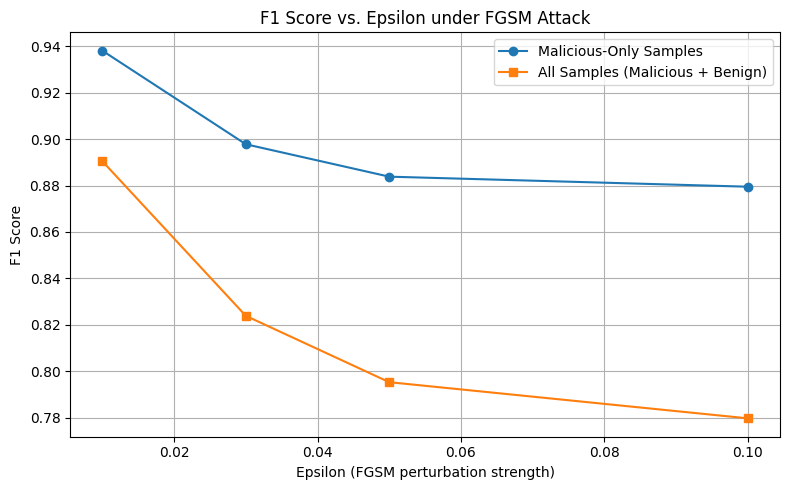

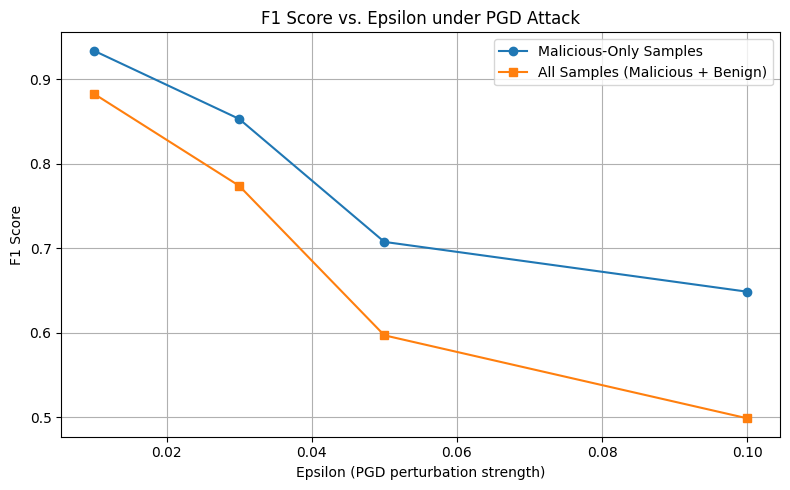

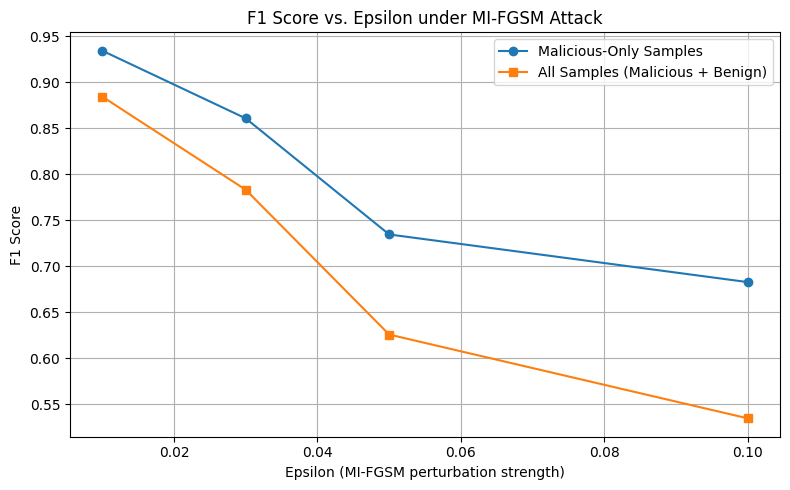

In [11]:
import matplotlib.pyplot as plt

def plot_results(f1_malicious_list, f1_all_list, epsilons, a_type="PGD"):
    plt.figure(figsize=(8, 5))
    plt.plot(epsilons, f1_malicious_list, marker='o', label='Malicious-Only Samples')
    plt.plot(epsilons, f1_all_list, marker='s', label='All Samples (Malicious + Benign)')
    plt.xlabel(f"Epsilon ({a_type} perturbation strength)")
    plt.ylabel("F1 Score")
    plt.title(f"F1 Score vs. Epsilon under {a_type} Attack")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

f1_malicious_scores = [entry['adversarial']['f1'] for entry in fgsm_mal]
f1_all_scores = [entry['adversarial']['f1'] for entry in fgsm_full]
plot_results(f1_malicious_scores, f1_all_scores, epsilons=[0.01, 0.03, 0.05, 0.1], a_type='FGSM')


f1_malicious_scores_pgd = [entry['adversarial']['f1'] for entry in pgd_mal]
f1_all_scores_pgd = [entry['adversarial']['f1'] for entry in pgd_full]

plot_results(f1_malicious_scores_pgd, f1_all_scores_pgd, epsilons=[0.01, 0.03, 0.05, 0.1], a_type='PGD')

f1_malicious_scores_mi = [entry['adversarial']['f1'] for entry in mi_mal]
f1_all_scores_mi = [entry['adversarial']['f1'] for entry in mi_full]

plot_results(f1_malicious_scores_mi, f1_all_scores_mi, epsilons=[0.01, 0.03, 0.05, 0.1], a_type='MI-FGSM')

